## Toxic Tweet Classification using Word Embeddings and Machine Learning Algorithms

Importing libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Performing Data Visualization and Cleaning

In [86]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/cyberbullying_tweets.csv')

In [87]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [88]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
None


In [89]:
data = data.rename(columns={'tweet_text' : 'tweet', 'cyberbullying_type' : 'sentiment'})

Removing duplicates from given tweets


In [90]:
data[data.duplicated()].shape

(36, 2)

In [91]:
data = data[~data.duplicated()]

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


Showing class balance/imbalance result

In [93]:
data.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

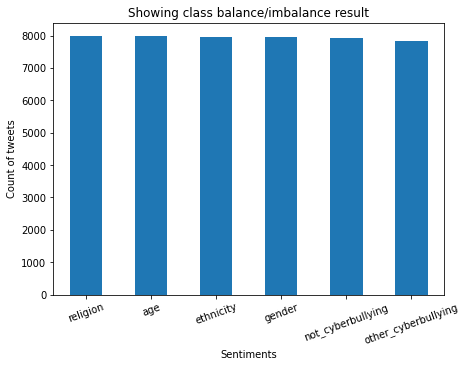

In [94]:
plt.figure(figsize=(7,5))
plt.title('Showing class balance/imbalance result');
data['sentiment'].value_counts().plot.bar(rot = 20);
plt.xlabel('Sentiments');
plt.ylabel('Count of tweets');
plt.show();

From above, we can see that dataset is **balanced** as there are equal number of tweets from different classes.

Importing and downloading different packages for data cleaning

In [95]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing nltk

In [96]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now, let's proceed towards basic cleaning of tweets

In [98]:
import re, string
import emoji
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def remove_emoji(text):
  """For removing the emojis from the text"""
  return emoji.replace_emoji(text, replace="", version=1.0)


def remove_entities(text):
  """Function for removing various entities from the text"""
  text = text.replace('\r', '').replace('\n', ' ').lower()  # For removing \n(new line) and \r(raw string) from the text and then lowercasing the text
  text = re.sub(r"(?:\@|https?\://)\S+", "", text)
  text = re.sub(r'[^\x00-\x7f]', r'', text)
  punctuation_words = string.punctuation
  table = text.maketrans('', '', punctuation_words)
  text = text.translate(table)
  text = [word for word in text.split() if word not in stop_words]
  text = ' '.join(text)
  text = ' '.join(word for word in text.split() if len(word)<14)
  return text


def remove_contractions(text):
  text = re.sub(r"can\'t", "can not", text)
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)
  return text


def remove_hashtags(text):
  new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
  new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text))
  return new_text2


def filter_characters(text):
  filtered = []
  for word in text.split(' '):
    if ('$' in word) | ('&' in word):
      filtered.append('')
    else:
      filtered.append(word)
  return ' '.join(filtered)


def remove_mult_spaces(text):
  return re.sub("\s\s+", " ", text)


def basic_cleaning(text):
  """Performing basic cleaning of text"""
  text = remove_emoji(text)
  text = remove_contractions(text)
  text = remove_entities(text)
  text = remove_hashtags(text)
  text = filter_characters(text)
  text = remove_mult_spaces(text)
  return text

Using basic_cleaning() function defined above to do basic cleaning

In [99]:
basic_clean_tweets = []
for text in data['tweet']:
  basic_clean_tweets.append(basic_cleaning(text))

In [100]:
basic_clean_df = pd.DataFrame(basic_clean_tweets, columns = ['Basic clean']);
basic_clean_df['sentiment'] = data['sentiment'].values
basic_clean_df.head()

,Basic clean,sentiment
0,words katandandre food crapilicious mkr,not_cyberbullying
1,aussietv white mkr theblock today sunrise stud...,not_cyberbullying
2,classy whore red velvet cupcakes,not_cyberbullying
3,meh p thanks heads concerned another angry dud...,not_cyberbullying
4,isis account pretending kurdish account like i...,not_cyberbullying


Removing duplicates from basic cleaned tweets

In [101]:
basic_clean_df.shape

(47656, 2)

In [102]:
basic_clean_df['Basic clean'].duplicated().sum()

2998

In [103]:
basic_clean_df.drop_duplicates('Basic clean', inplace = True)
basic_clean_df.shape

(44658, 2)

In [104]:
basic_clean_df['sentiment'].value_counts()

religion               7948
age                    7898
ethnicity              7751
not_cyberbullying      7648
gender                 7616
other_cyberbullying    5797
Name: sentiment, dtype: int64

Creating tweet_length column for basic cleaned tweets

In [105]:
text_length = []
for text in basic_clean_df['Basic clean']:
  tweet_length = len(text.split())
  text_length.append(tweet_length)

basic_clean_df['tweet_length'] = text_length
basic_clean_df.head()

,Basic clean,sentiment,tweet_length
0,words katandandre food crapilicious mkr,not_cyberbullying,5
1,aussietv white mkr theblock today sunrise stud...,not_cyberbullying,10
2,classy whore red velvet cupcakes,not_cyberbullying,5
3,meh p thanks heads concerned another angry dud...,not_cyberbullying,9
4,isis account pretending kurdish account like i...,not_cyberbullying,8


Showing count plot of tweets length

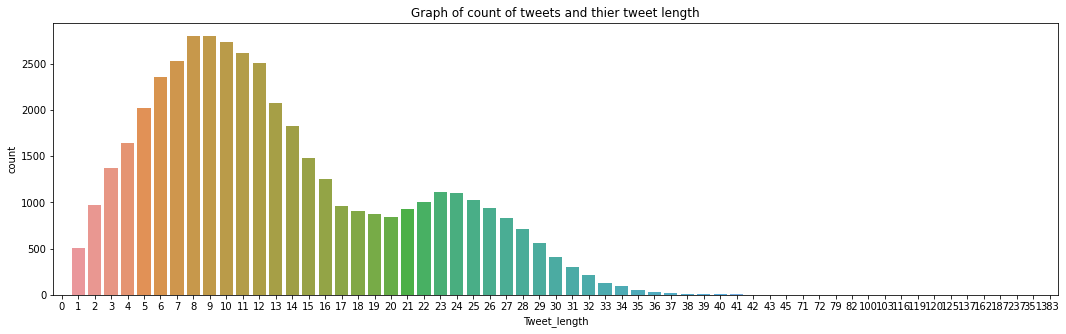

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,5))
ax = sns.countplot(x='tweet_length', data=basic_clean_df)  # Using countplot
plt.title('Graph of count of tweets and thier tweet length')
plt.ylabel('count')
plt.xlabel('Tweet_length')
plt.show()

From the above graph, we can see the distribution of length of cleaned tweets.

So, removing tweets of length greater than 100 and less than 1.

In [107]:
basic_clean_df = basic_clean_df[(basic_clean_df['tweet_length'] <= 100) & (basic_clean_df['tweet_length'] > 0)]

In [108]:
basic_clean_df.shape

(44645, 3)

In [109]:
max_length = np.max(basic_clean_df['tweet_length'])
print("Maximum length of tweet = ",max_length)

Maximum length of tweet =  100


### Proceeding towards Stemming and Lemmatization techniques.

For further cleaning in this section, we will be generating three columns.

1.   Stemming of basic cleaned tweets
2.   Lemmatization of basic cleaned tweets
3.   Lemmatization followed by Stemming of cleaned tweets.

We will select one techinique from above three based on thier performance.


In [110]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [111]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

We will use SnowballStemmer

In [112]:
from nltk.stem import WordNetLemmatizer,SnowballStemmer

def stemming(text):
  tokenized = nltk.word_tokenize(text)
  sb = SnowballStemmer(language = 'english')
  return ' '.join([sb.stem(words) for words in tokenized])


def lemmatize(text):
  tokenized = nltk.word_tokenize(text)
  lm = WordNetLemmatizer()
  return ' '.join([lm.lemmatize(words) for words in tokenized])

Using above functions to do stemming and lemmatization on basic clean tweets

In [113]:
# For stemming and lemmatization
stem_tweets = []
lemma_tweets = []
lemma_stem_tweets = [];

# For stemming and lemmatization
for text in basic_clean_df['Basic clean']:
  stem_tweets.append(stemming(text));      # Stemming
  lemma_tweets.append(lemmatize(text));    # Lemmatize

# For lemmatization followed by stemming
for text in lemma_tweets:
  lemma_stem_tweets.append(stemming(text));

Showing three results of Stemming, Lemmatization and Lemma+Stemming

In [114]:
basic_clean_df['Stemming'] = stem_tweets;
basic_clean_df['Lemmatization'] = lemma_tweets;
basic_clean_df['Lemma_Stemming'] = lemma_stem_tweets;
basic_clean_df.head()

# We can see that in stemming is just removing last few characters of words.
# Whereas lemmatization is considering context of words and converting to its
# meaningful baseform.

,Basic clean,sentiment,tweet_length,Stemming,Lemmatization,Lemma_Stemming
0,words katandandre food crapilicious mkr,not_cyberbullying,5,word katandandr food crapilici mkr,word katandandre food crapilicious mkr,word katandandr food crapilici mkr
1,aussietv white mkr theblock today sunrise stud...,not_cyberbullying,10,aussietv white mkr theblock today sunris studi...,aussietv white mkr theblock today sunrise stud...,aussietv white mkr theblock today sunris studi...
2,classy whore red velvet cupcakes,not_cyberbullying,5,classi whore red velvet cupcak,classy whore red velvet cupcake,classi whore red velvet cupcak
3,meh p thanks heads concerned another angry dud...,not_cyberbullying,9,meh p thank head concern anoth angri dude twitter,meh p thanks head concerned another angry dude...,meh p thank head concern anoth angri dude twitter
4,isis account pretending kurdish account like i...,not_cyberbullying,8,isi account pretend kurdish account like islam...,isi account pretending kurdish account like is...,isi account pretend kurdish account like islam...


Encoding the sentiment column.

In [115]:
basic_clean_df['sentiment'] = basic_clean_df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4, 'other_cyberbullying':5})

Word Cloud for religion sentiment

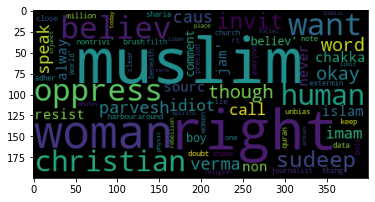

In [116]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = basic_clean_df[basic_clean_df['sentiment']==0]['Stemming'].values
wordCloud = WordCloud().generate(str(text))
plt.imshow(wordCloud)
plt.savefig('religion.png')

Word Cloud for age sentiment

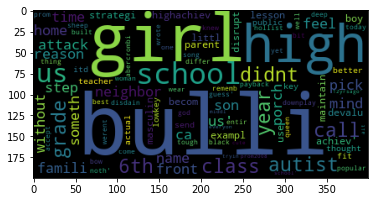

In [117]:
text = basic_clean_df[basic_clean_df['sentiment']==1]['Stemming'].values
wordCloud = WordCloud().generate(str(text))
plt.imshow(wordCloud)
plt.savefig('age.png')

Word Cloud for ethnicity sentiment

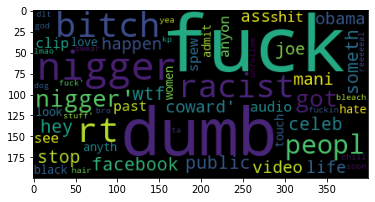

In [118]:
text = basic_clean_df[basic_clean_df['sentiment']==2]['Stemming'].values
wordCloud = WordCloud().generate(str(text))
plt.imshow(wordCloud)
plt.savefig('ethnicity.png')

Word Cloud for not_cyberbullying sentiment

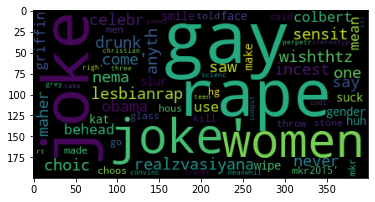

In [119]:
text = basic_clean_df[basic_clean_df['sentiment']==3]['Stemming'].values
wordCloud = WordCloud().generate(str(text))
plt.imshow(wordCloud)
plt.savefig('not_cyberbullying.png')

Word Cloud for gender sentiment

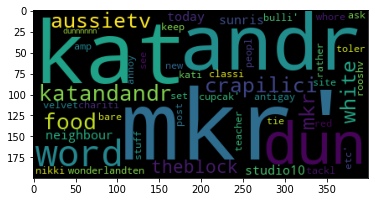

In [120]:
text = basic_clean_df[basic_clean_df['sentiment']==4]['Stemming'].values
wordCloud = WordCloud().generate(str(text))
plt.imshow(wordCloud)
plt.savefig('gender.png')

Word Cloud for other cyberbullying sentiment

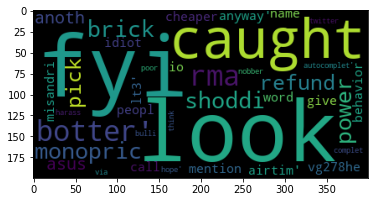

In [121]:
text = basic_clean_df[basic_clean_df['sentiment']==5]['Stemming'].values
wordCloud = WordCloud().generate(str(text))
plt.imshow(wordCloud)
plt.savefig('other.png')

## Proceeding towards Word embeddings

For further processing, we will convert our results of - 

*   Stemming
*   Lemmatization
*   Lemmatization followed by stemming

to vectors.
To achieve this, we will be using following word-embeddings -


1.   Bag of words
2.   Tf-idf (Term Frequency-Inverse Document Frequency)
3.   GloVe word embedding
4.   Word2vec embedding


Before going for these, lets first split the dataset in training and testing.


Importing libraries

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
basic_clean_df['sentiment'].value_counts()

0    7948
1    7897
2    7748
4    7645
3    7613
5    5794
Name: sentiment, dtype: int64

Train/test split

In [124]:
# For X(training data) - dropping sentiment column
sampled_df = basic_clean_df.sample(34764) # Here, we are performing random sampling to get rid of class imbalance
X = sampled_df.drop(columns='sentiment');
# y = sentiments
y = sampled_df['sentiment']
# Splitting 20% test and 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42);
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape);

(27811, 5) (6953, 5) (27811,) (6953,)


Defining different varaiables for Stemming, lemmatization and lemma_stem


In [125]:
# For training -
X_stem_train = X_train['Stemming']
X_lemma_train = X_train['Lemmatization']
X_lemmaStem_train = X_train['Lemma_Stemming']

# For testing -
X_stem_test = X_test['Stemming']
X_lemma_test = X_test['Lemmatization']
X_lemmaStem_test = X_test['Lemma_Stemming']

print(X_stem_train.shape,X_lemma_train.shape,X_lemmaStem_train.shape)
print(X_stem_test.shape,X_lemma_test.shape,X_lemmaStem_test.shape)

(27811,) (27811,) (27811,)
(6953,) (6953,) (6953,)


Now, we will use above variables for different embeddings.

### Bag of words

Importing CountVectorizer

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

Creating objects of CountVectorizer

In [127]:
bow1 = CountVectorizer();
bow2 = CountVectorizer();
bow3 = CountVectorizer();
# for stemming
bow_cv1 = bow1.fit_transform(X_stem_train);
# for lemmatization
bow_cv2 = bow2.fit_transform(X_lemma_train);
# for lemma-stemming
bow_cv3 = bow3.fit_transform(X_lemmaStem_train);

print(bow_cv1.shape);
print(bow_cv2.shape);
print(bow_cv3.shape);

(27811, 26632)
(27811, 31862)
(27811, 26488)


### Tf-idf (Term Frequency-Inverse Document Frequency)

Importing TfidfTransformer

In [128]:
from sklearn.feature_extraction.text import TfidfTransformer

Creating objects of TfidfTransformer

In [129]:
tfid1 = TfidfTransformer(use_idf=True).fit(bow_cv1)
tfid2 = TfidfTransformer(use_idf=True).fit(bow_cv2)
tfid3 = TfidfTransformer(use_idf=True).fit(bow_cv3)
# for stemming
tf_cv1 = tfid1.transform(bow_cv1);
# for lemmatization
tf_cv2 = tfid2.transform(bow_cv2);
# for lemma-stemming
tf_cv3 = tfid3.transform(bow_cv3);

print(tf_cv1.shape);
print(tf_cv2.shape);
print(tf_cv3.shape);

(27811, 26632)
(27811, 31862)
(27811, 26488)


### GloVe (Global Vectors) Word Embedding

Downloading glove python library

In [130]:
! pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Creating two lists- tweet_text and tweet_sentiment to store stemmed tweets and its corresponding sentiment so that we can train glove embeddings.

In [131]:
tweet_text = []
tweet_sentiment = []
for key, value in sampled_df.iterrows():
  tweet = value['Stemming'].split()
  tweet_text.append(tweet)
  tweet_sentiment.append(value['sentiment'])

Now training glove to create embeddings

In [132]:
from glove import Corpus, Glove

corpus = Corpus()  # Creating a corpus object that will generate the co-occurence matrix
corpus.fit(tweet_text, window = 10)  # Training the corpus to generate the co-occurence matrix that will be used by GloVe
glove = Glove(no_components=300, learning_rate=0.05)  # Creating a glove object that will use the matrix created above to create embeddings
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)  # Training glove to create embeddings
glove.add_dictionary(corpus.dictionary)  # Adding corpus dictionary to glove dictionary
glove.save('glove.model')  # Saving the model

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


Iterating over stemmed tweets and storing the word embeddings in a list

In [133]:
word_embeddings = []
for key, value in sampled_df.iterrows():
  words = value['Stemming'].split()
  embedding = np.zeros(300)
  for j in range(len(words)):  # Iterating over all words in the tweet to calculate mean of GloVe embedding
    embedding += np.array(glove.word_vectors[glove.dictionary[words[j]]])
  embedding = embedding/len(words)
  word_embeddings.append(embedding)

Creating a dataframe for word embeddings and their corresponding sentiment

In [134]:
cols = []
for i in range(300):
  col_name = "col"+str(i+1)
  cols.append(col_name)
embeddings_df = pd.DataFrame(word_embeddings, columns = cols)
embeddings_df['sentiments'] = tweet_sentiment
embeddings_df

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col292,col293,col294,col295,col296,col297,col298,col299,col300,sentiments
0,-0.010488,-0.141449,-0.125763,0.137863,-0.042919,-0.161793,-0.174265,0.111051,0.149426,-0.183233,...,-0.133546,0.203822,0.122408,-0.135338,0.119570,0.039226,0.105371,0.173629,-0.024546,1
1,0.014022,-0.023208,0.013520,0.077514,-0.015169,-0.003161,-0.009180,0.032143,0.103616,0.053251,...,-0.002666,-0.030447,0.094755,0.012016,0.065441,-0.072001,0.005129,0.079692,-0.021465,0
2,0.019534,-0.033448,0.037024,0.058803,0.006806,0.090274,-0.104040,-0.063858,0.053173,0.042634,...,-0.008252,-0.018983,0.054164,-0.072271,0.011508,-0.010554,0.019012,0.068159,-0.007738,4
3,0.150140,-0.053325,-0.075086,0.089030,0.035844,-0.014693,-0.098510,0.033929,0.116979,0.062169,...,-0.068207,-0.038232,0.130235,0.061419,0.020608,-0.008296,-0.076880,0.100943,0.142494,2
4,0.148587,0.004241,-0.097034,0.104927,0.039867,0.053075,-0.039868,0.063848,0.136290,0.058852,...,-0.049837,-0.057395,0.151547,0.049809,0.052583,-0.130385,-0.069137,0.086726,0.183640,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34759,0.031549,-0.031093,0.041115,0.041290,-0.001482,0.041048,-0.020851,0.036323,0.080188,0.028260,...,0.010494,-0.037061,0.062842,0.002164,0.039006,-0.086631,-0.017114,0.090164,-0.042738,0
34760,-0.037343,-0.067555,-0.017883,0.040652,0.019907,0.047365,-0.010334,-0.015513,0.071874,0.099516,...,-0.055394,-0.020993,0.083768,0.060164,0.053727,-0.047560,0.018521,0.063183,0.096219,0
34761,0.049337,-0.054486,-0.039987,0.023085,-0.021625,-0.003506,-0.065639,0.022711,0.095322,-0.033258,...,-0.083904,0.058474,0.097378,-0.029082,0.008810,-0.033789,-0.000055,0.107189,0.053932,4
34762,0.070745,0.002388,-0.041479,0.083049,-0.079486,0.017647,-0.031181,0.024578,0.098211,0.059688,...,0.017540,-0.023552,0.084114,0.046467,0.064477,-0.067742,-0.025115,0.067322,-0.006824,5


## Baseline Technique - Naive Bayes

## Training Multinomial Naive Bayes using Bag of words and Tf-idf Embedding

Importing multinomial naive bayes

In [135]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB

Importing evaluation metrics

In [136]:
from sklearn.metrics import classification_report,accuracy_score


k fold cross validation (k=5)

In [137]:
from sklearn.model_selection import KFold

For bag of words


In [138]:
y_train = np.array(y_train)
model = 1
accuracy_val = 0
accuracy_train = 0
kf = KFold(n_splits = 5)
for train_index, val_index in kf.split(bow_cv1):
  X_KFold_train, X_KFold_val = bow_cv1[train_index], bow_cv1[val_index]
  Y_KFold_train, Y_KFold_val = y_train[train_index], y_train[val_index]
  mnb = MultinomialNB()
  mnb.fit(X_KFold_train, Y_KFold_train)
  Y_pred = mnb.predict(X_KFold_val)
  YY_pred = mnb.predict(X_KFold_train)
  print("Classification report for K-Fold model "+str(model))
  print("For validation set -")
  print(classification_report(Y_KFold_val, Y_pred))
  print("For training set -")
  accuracy_val += accuracy_score(Y_KFold_val, Y_pred)
  print(classification_report(Y_KFold_train, YY_pred))
  accuracy_train += accuracy_score(Y_KFold_train, YY_pred)
  model += 1

Classification report for K-Fold model 1
For validation set -
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1006
           1       0.73      0.99      0.84       976
           2       0.81      0.95      0.87       927
           3       0.81      0.82      0.81       957
           4       0.70      0.45      0.55       978
           5       0.60      0.29      0.39       719

    accuracy                           0.77      5563
   macro avg       0.74      0.75      0.73      5563
weighted avg       0.75      0.77      0.74      5563

For training set -
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3951
           1       0.77      0.99      0.86      3929
           2       0.86      0.98      0.91      3878
           3       0.88      0.88      0.88      3745
           4       0.85      0.58      0.69      3831
           5       0.86      0.51      0.64      29

In [139]:
avg_accuracy1 = accuracy_val/5
print("Average accuracy obtained on vaidation set= "+str(avg_accuracy1))
avg_accuracy2 = accuracy_train/5
print("Average accuracy obtained on training set= "+str(avg_accuracy2))

Average accuracy obtained on vaidation set= 0.7586923360884118
Average accuracy obtained on training set= 0.8358473237968311


We can see that, on training set we are getting 89% accuracy and on validation set we are getting 84% accuracy for Bag of words

For Tf-idf

In [140]:
y_train = np.array(y_train)
model = 1
accuracy_val = 0
accuracy_train = 0
kf = KFold(n_splits = 5)
for train_index, val_index in kf.split(tf_cv1):
  X_KFold_train, X_KFold_val = tf_cv1[train_index], tf_cv1[val_index]
  Y_KFold_train, Y_KFold_val = y_train[train_index], y_train[val_index]
  mnb = MultinomialNB()
  mnb.fit(X_KFold_train, Y_KFold_train)
  Y_pred = mnb.predict(X_KFold_val)
  YY_pred = mnb.predict(X_KFold_train)
  print("Classification report for K-Fold model "+str(model))
  print("For validation set -")
  print(classification_report(Y_KFold_val, Y_pred))
  print("For training set -")
  accuracy_val += accuracy_score(Y_KFold_val, Y_pred)
  print(classification_report(Y_KFold_train, YY_pred))
  accuracy_train += accuracy_score(Y_KFold_train, YY_pred)
  model += 1

Classification report for K-Fold model 1
For validation set -
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1006
           1       0.68      0.99      0.80       976
           2       0.78      0.92      0.85       927
           3       0.80      0.82      0.81       957
           4       0.68      0.45      0.54       978
           5       0.64      0.13      0.22       719

    accuracy                           0.74      5563
   macro avg       0.73      0.72      0.68      5563
weighted avg       0.73      0.74      0.70      5563

For training set -
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3951
           1       0.73      0.99      0.84      3929
           2       0.85      0.96      0.90      3878
           3       0.87      0.89      0.88      3745
           4       0.84      0.60      0.70      3831
           5       0.93      0.36      0.52      29

In [141]:
avg_accuracy1 = accuracy_val/5
print("Average accuracy obtained on vaidation set= "+str(avg_accuracy1))
avg_accuracy2 = accuracy_train/5
print("Average accuracy obtained on training set= "+str(avg_accuracy2))

Average accuracy obtained on vaidation set= 0.7339538804409858
Average accuracy obtained on training set= 0.8185609916102876


 Transforming set testing for different word embeddings


In [142]:
# For Bag of words 
bow_cv1_test = bow1.transform(X_stem_test)
bow_cv2_test = bow2.transform(X_lemma_test)
bow_cv3_test = bow3.transform(X_lemmaStem_test)

# For Tf-idf
tf_cv1_test = tfid1.transform(bow_cv1_test);
tf_cv2_test = tfid2.transform(bow_cv2_test);
tf_cv3_test = tfid3.transform(bow_cv3_test);

print(bow_cv1_test.shape,bow_cv2_test.shape,bow_cv3_test.shape);
print(tf_cv1_test.shape,tf_cv2_test.shape,tf_cv3_test.shape);

(6953, 26632) (6953, 31862) (6953, 26488)
(6953, 26632) (6953, 31862) (6953, 26488)


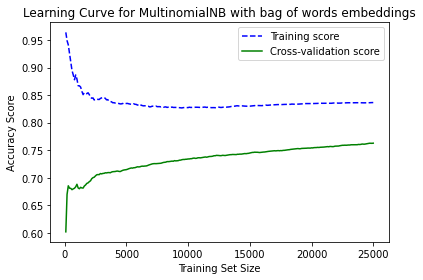

In [143]:
from sklearn.model_selection import learning_curve

sizes, training_scores, testing_scores = learning_curve(MultinomialNB(), bow_cv1, y_train, cv=10, scoring='accuracy', train_sizes=np.linspace(100, 25000, 250, dtype=int))
  
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# Dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("Learning Curve for MultinomialNB with bag of words embeddings")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

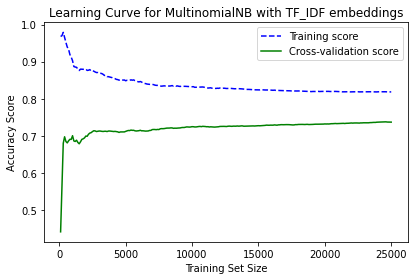

In [144]:
sizes, training_scores, testing_scores = learning_curve(MultinomialNB(), tf_cv1, y_train, cv=10, scoring='accuracy', train_sizes=np.linspace(100, 25000, 250, dtype=int))
  
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# Dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("Learning Curve for MultinomialNB with TF_IDF embeddings")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Creating models

In [145]:
# For bag of words - 
nb_bow_stem = MultinomialNB();
nb_bow_lemma = MultinomialNB();
nb_bow_lemmaStem = MultinomialNB();

# for tf-idf - 
nb_tf_stem = MultinomialNB();
nb_tf_lemma = MultinomialNB();
nb_tf_lemmaStem = MultinomialNB();

Training the models 

In [146]:
# For bag of words - 
nb_bow_stem.fit(bow_cv1,y_train);
nb_bow_lemma.fit(bow_cv2,y_train);
nb_bow_lemmaStem.fit(bow_cv3,y_train);

# For tf-idf - 
nb_tf_stem.fit(tf_cv1,y_train);
nb_tf_lemma.fit(tf_cv1,y_train);
nb_tf_lemmaStem.fit(tf_cv1,y_train);

Prediction on test set

In [147]:
# For bag of words - 
nb_bow_stem_pred = nb_bow_stem.predict(bow_cv1_test);
nb_bow_lemma_pred = nb_bow_lemma.predict(bow_cv2_test);
nb_bow_lemmaStem_pred = nb_bow_lemmaStem.predict(bow_cv3_test);

# For tf-idf - 
nb_tf_stem_pred = nb_tf_stem.predict(tf_cv1_test);
nb_tf_lemma_pred = nb_tf_lemma.predict(tf_cv1_test);
nb_tf_lemmaStem_pred = nb_tf_lemmaStem.predict(tf_cv1_test);

Evaluation metrics

In [148]:
from sklearn.metrics import classification_report, confusion_matrix

Printing reports

In [149]:
# For Bag of words - 
print('Classification Report for Naive Bayes on bag of word with stemming:\n',classification_report(y_test, nb_bow_stem_pred))
print('Classification Report for Naive Bayes on bag of word with lemmatization:\n',classification_report(y_test, nb_bow_lemma_pred))
print('Classification Report for Naive Bayes on bag of word with lemma_stemming:\n',classification_report(y_test, nb_bow_lemmaStem_pred))

Classification Report for Naive Bayes on bag of word with stemming:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87      1239
           1       0.71      0.99      0.83      1227
           2       0.81      0.95      0.88      1202
           3       0.81      0.80      0.80      1175
           4       0.66      0.39      0.49      1202
           5       0.59      0.29      0.39       908

    accuracy                           0.75      6953
   macro avg       0.73      0.73      0.71      6953
weighted avg       0.74      0.75      0.72      6953

Classification Report for Naive Bayes on bag of word with lemmatization:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87      1239
           1       0.72      0.99      0.83      1227
           2       0.81      0.96      0.88      1202
           3       0.80      0.80      0.80      1175
           4       0.65      0.40      0.49

In [150]:
# For Tf-idf - 
print('Classification Report for Naive Bayes on Ti-idf with stemming:\n', classification_report(y_test, nb_tf_stem_pred))
print('Classification Report for Naive Bayes on Ti-idf with lemmatization:\n', classification_report(y_test, nb_tf_lemma_pred))
print('Classification Report for Naive Bayes on Ti-idf with lemma_stemming:\n', classification_report(y_test, nb_tf_lemmaStem_pred))

Classification Report for Naive Bayes on Ti-idf with stemming:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85      1239
           1       0.67      0.98      0.79      1227
           2       0.79      0.92      0.85      1202
           3       0.79      0.79      0.79      1175
           4       0.64      0.39      0.49      1202
           5       0.59      0.14      0.23       908

    accuracy                           0.73      6953
   macro avg       0.70      0.70      0.67      6953
weighted avg       0.71      0.73      0.69      6953

Classification Report for Naive Bayes on Ti-idf with lemmatization:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85      1239
           1       0.67      0.98      0.79      1227
           2       0.79      0.92      0.85      1202
           3       0.79      0.79      0.79      1175
           4       0.64      0.39      0.49      1202

Analysis about stemming and lemmatization- We can see that accuracy is very less affected by stemming and lemmatization. And since stemming is performing little better than lemmatization and it is much optimized as well, So we will be going for stemming for rest of analysis.

Morever, we can see that test accuracy of bag of words is 85% and that of Tf-idf is 83%.

## Training Gaussian Naive Bayes using GloVe Embedding

Performing train-test split for using Gaussian Naive Bayes on glove embeddings

In [151]:
X = embeddings_df.drop(['sentiments'], axis=1)
Y = embeddings_df['sentiments']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
print(X_train.shape, X_test.shape)

(27811, 300) (6953, 300)


Creating an object and training Gaussian Naive Bayes

In [152]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB()

Performing predictions on the test set

In [153]:
Y_pred = gnb.predict(X_test)

Evaluating the performance of the model

In [154]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.6922191859628937


Displaying the classification report

In [155]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1246
           1       0.86      0.88      0.87      1210
           2       0.85      0.72      0.78      1209
           3       0.79      0.69      0.74      1197
           4       0.50      0.57      0.53      1200
           5       0.29      0.27      0.28       891

    accuracy                           0.69      6953
   macro avg       0.68      0.67      0.67      6953
weighted avg       0.70      0.69      0.69      6953



Using K-Fold validation on the training set

In [156]:
from sklearn.model_selection import KFold

X_train_numpy = np.array(X_train)
Y_train_numpy = np.array(Y_train)

model = 1
accuracy_val = 0
accuracy_train = 0
kf = KFold(n_splits = 5)
for train_index, val_index in kf.split(X_train_numpy):
  X_KFold_train, X_KFold_val = X_train_numpy[train_index], X_train_numpy[val_index]
  Y_KFold_train, Y_KFold_val = Y_train_numpy[train_index], Y_train_numpy[val_index]
  gnb = GaussianNB()
  gnb.fit(X_KFold_train, Y_KFold_train)
  Y_pred = gnb.predict(X_KFold_val)
  Y_pred_train = gnb.predict(X_KFold_train)
  print("Classification report for K-Fold model "+str(model))
  print("For validation set -")
  print(classification_report(Y_KFold_val, Y_pred))
  print("For training set -")
  accuracy_val += accuracy_score(Y_KFold_val, Y_pred)
  print(classification_report(Y_KFold_train, Y_pred_train))
  accuracy_train += accuracy_score(Y_KFold_train, Y_pred_train)
  model += 1 

Classification report for K-Fold model 1
For validation set -
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       994
           1       0.88      0.86      0.87       960
           2       0.83      0.72      0.77       947
           3       0.77      0.70      0.73       904
           4       0.49      0.56      0.52       975
           5       0.34      0.29      0.31       783

    accuracy                           0.69      5563
   macro avg       0.68      0.67      0.67      5563
weighted avg       0.69      0.69      0.68      5563

For training set -
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      3956
           1       0.89      0.88      0.88      3962
           2       0.86      0.74      0.79      3851
           3       0.80      0.70      0.74      3776
           4       0.50      0.58      0.54      3836
           5       0.34      0.30      0.32      28

In [157]:
avg_accuracy1 = accuracy_val/5
print("Average accuracy obtained on vaidation set= "+str(avg_accuracy1))
avg_accuracy2 = accuracy_train/5
print("Average accuracy obtained on training set= "+str(avg_accuracy2))

Average accuracy obtained on vaidation set= 0.6987886652597494
Average accuracy obtained on training set= 0.7002355426274446


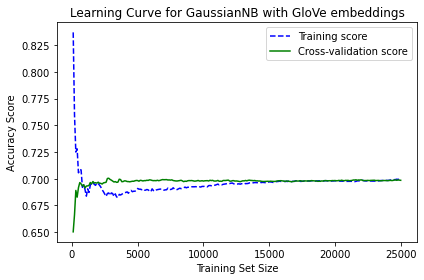

In [158]:
sizes, training_scores, testing_scores = learning_curve(GaussianNB(), X_train, Y_train, cv=10, scoring='accuracy', train_sizes=np.linspace(100, 25000, 250, dtype=int))
  
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# Dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("Learning Curve for GaussianNB with GloVe embeddings")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Using Logistic Regression with OVR for GloVe Embeddings.

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

lr = LogisticRegression(multi_class = 'ovr', max_iter = 10000)

model = 1
accuracy_val = 0
accuracy_train = 0
kf = KFold(n_splits = 5)
for train_index, val_index in kf.split(X_train_numpy):
  X_KFold_train, X_KFold_val = X_train_numpy[train_index], X_train_numpy[val_index]
  Y_KFold_train, Y_KFold_val = Y_train_numpy[train_index], Y_train_numpy[val_index]
  lr.fit(X_KFold_train, Y_KFold_train)
  Y_pred = lr.predict(X_KFold_val)
  Y_pred_train = lr.predict(X_KFold_train)
  print("Classification report for K-Fold model "+str(model))
  print("For validation set -")
  print(classification_report(Y_KFold_val, Y_pred))
  print("For training set -")
  accuracy_val += accuracy_score(Y_KFold_val, Y_pred)
  print(classification_report(Y_KFold_train, Y_pred_train))
  accuracy_train += accuracy_score(Y_KFold_train, Y_pred_train)
  model += 1

Classification report for K-Fold model 1
For validation set -
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       994
           1       0.89      0.94      0.91       960
           2       0.85      0.96      0.90       947
           3       0.79      0.80      0.79       904
           4       0.53      0.57      0.55       975
           5       0.55      0.31      0.39       783

    accuracy                           0.77      5563
   macro avg       0.75      0.75      0.74      5563
weighted avg       0.75      0.77      0.75      5563

For training set -
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3956
           1       0.89      0.96      0.92      3962
           2       0.88      0.95      0.92      3851
           3       0.81      0.78      0.80      3776
           4       0.54      0.59      0.57      3836
           5       0.56      0.31      0.40      28

In [160]:
avg_accuracy1 = accuracy_val/5
print("Average accuracy obtained on vaidation set= "+str(avg_accuracy1))
avg_accuracy2 = accuracy_train/5
print("Average accuracy obtained on training set= "+str(avg_accuracy2))

Average accuracy obtained on vaidation set= 0.772967750722123
Average accuracy obtained on training set= 0.7751878973700769


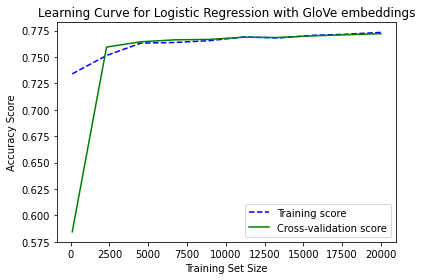

In [161]:
sizes, training_scores, testing_scores = learning_curve(LogisticRegression(multi_class = 'ovr', max_iter = 10000), X_train, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(100, 20000, 10, dtype=int))
  
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
  
# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
  
# Dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
  
# Drawing plot
plt.title("Learning Curve for Logistic Regression with GloVe embeddings")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [162]:
def conf_matrix(y, y_pred, title, labels):
  fig, ax =plt.subplots(figsize=(10,10))
  ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size":30})
  plt.title(title, fontsize=25)
  ax.xaxis.set_ticklabels(labels, fontsize=10,rotation = 30) 
  ax.yaxis.set_ticklabels(labels, fontsize=10)
  ax.set_ylabel('Test', fontsize=25)
  ax.set_xlabel('Predicted', fontsize=25)
  plt.show()
class_labels = ['religion','age','ethnicity','gender','not_cyberbullying','other_cyberbullying']

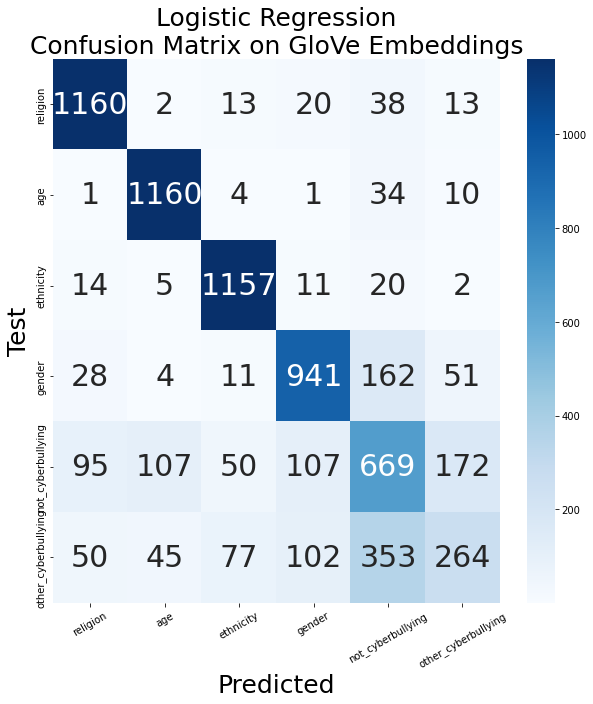

In [163]:
lr = LogisticRegression(multi_class = 'ovr', max_iter = 10000)
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
conf_matrix(Y_test, Y_pred, 'Logistic Regression\nConfusion Matrix on GloVe Embeddings', class_labels)

## Using SVM for GloVe Embeddings

In [164]:
from sklearn import svm

poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo')

model = 1
accuracy_val = 0
accuracy_train = 0
kf = KFold(n_splits = 5)
for train_index, val_index in kf.split(X_train_numpy):
  X_KFold_train, X_KFold_val = X_train_numpy[train_index], X_train_numpy[val_index]
  Y_KFold_train, Y_KFold_val = Y_train_numpy[train_index], Y_train_numpy[val_index]
  poly.fit(X_KFold_train, Y_KFold_train)
  Y_pred = poly.predict(X_KFold_val)
  Y_pred_train = poly.predict(X_KFold_train)
  print("Classification report for K-Fold model "+str(model))
  print("For validation set -")
  print(classification_report(Y_KFold_val, Y_pred))
  print("For training set -")
  accuracy_val += accuracy_score(Y_KFold_val, Y_pred)
  print(classification_report(Y_KFold_train, Y_pred_train))
  accuracy_train += accuracy_score(Y_KFold_train, Y_pred_train)
  model += 1

Classification report for K-Fold model 1
For validation set -
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       994
           1       0.95      0.91      0.93       960
           2       0.93      0.93      0.93       947
           3       0.89      0.74      0.81       904
           4       0.45      0.82      0.58       975
           5       0.60      0.17      0.26       783

    accuracy                           0.76      5563
   macro avg       0.79      0.74      0.73      5563
weighted avg       0.79      0.76      0.75      5563

For training set -
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3956
           1       0.95      0.93      0.94      3962
           2       0.94      0.92      0.93      3851
           3       0.91      0.73      0.81      3776
           4       0.46      0.84      0.59      3836
           5       0.71      0.18      0.29      28

In [165]:
avg_accuracy1 = accuracy_val/5
print("Average accuracy obtained on vaidation set= "+str(avg_accuracy1))
avg_accuracy2 = accuracy_train/5
print("Average accuracy obtained on training set= "+str(avg_accuracy2))

Average accuracy obtained on vaidation set= 0.7612456654361474
Average accuracy obtained on training set= 0.7712685691896606


In [166]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
X_train = StandardScaler().fit_transform(X_train)
tsne = TSNE(n_components = 2, random_state = 0)
tsne_res = tsne.fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


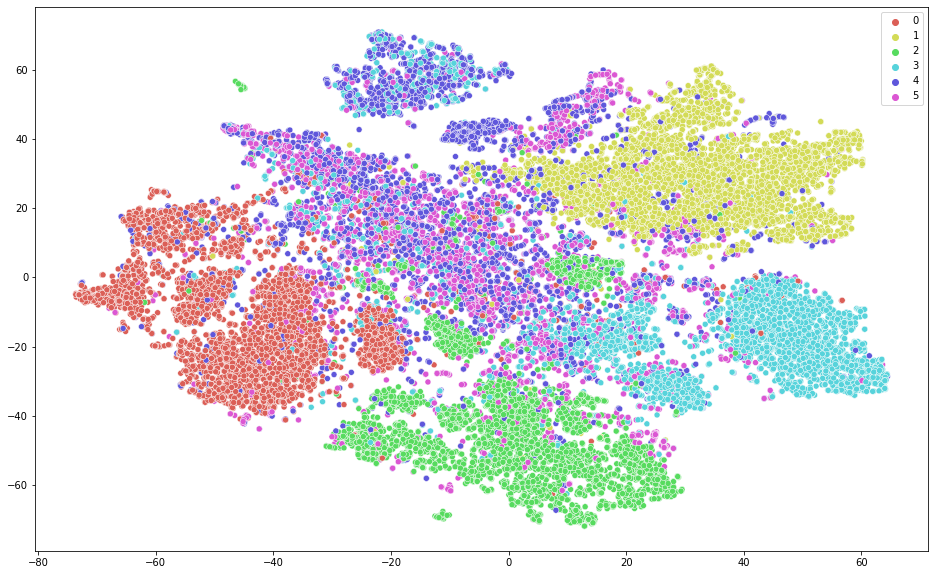

In [167]:
plt.figure(figsize=(16, 10))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = Y_train_numpy, palette = sns.hls_palette(6), legend = 'full')